In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.4.0


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # 28 * 28 -> (28+1-5) 24 * 24
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # 20 * 20
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # x: 1 * 28 * 28
        x = F.relu(self.conv1(x)) # 20 * 24 * 24
        x = F.max_pool2d(x,2,2) # 12 * 12
        x = F.relu(self.conv2(x)) # 8 * 8
        x = F.max_pool2d(x,2,2) # 4 *4 
        x = x.view(-1, 4*4*50) # reshape (5 * 2 * 10), view(5, 20) -> (5 * 20)
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        # return x
        return F.log_softmax(x, dim=1) # log probability
        

In [13]:
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True,
                            transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [18]:
mnist_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [19]:
data = [d[0].data.cpu().numpy() for d in mnist_data]

In [23]:
np.mean(data)

0.13066062

In [24]:
np.std(data)

0.30810776

In [25]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        pred = model(data) # batch_size * 10
        loss = F.nll_loss(pred, target) 
        
        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print("Train Epoch: {}, iteration: {}, Loss: {}".format(
                epoch, idx, loss.item()))

In [26]:
def test(model, device, test_loader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data) # batch_size * 10
            total_loss += F.nll_loss(output, target, reduction="sum").item() 
            pred = output.argmax(dim=1) # batch_size * 1
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    total_loss /= len(test_loader.dataset)
    acc = correct/len(test_loader.dataset) * 100.
    print("Test loss: {}, Accuracy: {}".format(total_loss, acc))

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", train=True, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
           ])),
    batch_size=batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", train=False, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
           ])),
    batch_size=batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

lr = 0.01
momentum  = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    
torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 0, iteration: 0, Loss: 2.302948474884033
Train Epoch: 0, iteration: 100, Loss: 0.6758238077163696
Train Epoch: 0, iteration: 200, Loss: 0.24391598999500275
Train Epoch: 0, iteration: 300, Loss: 0.2818746864795685
Train Epoch: 0, iteration: 400, Loss: 0.16662506759166718
Train Epoch: 0, iteration: 500, Loss: 0.07909899950027466
Train Epoch: 0, iteration: 600, Loss: 0.11095397919416428
Train Epoch: 0, iteration: 700, Loss: 0.14238065481185913
Train Epoch: 0, iteration: 800, Loss: 0.12140517681837082
Train Epoch: 0, iteration: 900, Loss: 0.07374545186758041
Train Epoch: 0, iteration: 1000, Loss: 0.11379572749137878
Train Epoch: 0, iteration: 1100, Loss: 0.06132367625832558
Train Epoch: 0, iteration: 1200, Loss: 0.15158073604106903
Train Epoch: 0, iteration: 1300, Loss: 0.03921222314238548
Train Epoch: 0, iteration: 1400, Loss: 0.13724789023399353
Train Epoch: 0, iteration: 1500, Loss: 0.17914558947086334
Train Epoch: 0, iteration: 1600, Loss: 0.02228853665292263
Train Epoch: 

# CNN 迁移学习

In [7]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.5.0


In [8]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

input_size = 224

In [9]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
        batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
img = next(iter(dataloaders_dict["val"]))[0]

In [22]:
img.shape

torch.Size([32, 3, 224, 224])

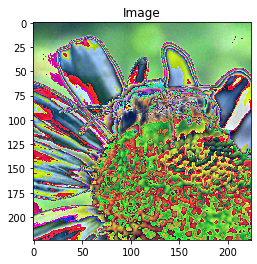

In [21]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[10], title='Image')


In [23]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("model not implemented")
        return None, None
        
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, 
                    num_classes, feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [25]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels) 
                    
                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)    
    return model, val_acc_history

In [26]:
model_ft = model_ft.to(device)

In [27]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_ft.parameters()), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()


In [28]:
_, ohist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.8593878531065143, acc: 0.3524590163934426
Phase val loss: 0.698552714843376, acc: 0.5359477124183006
Phase train loss: 0.5913237548265301, acc: 0.6516393442622951
Phase val loss: 0.4470775953305313, acc: 0.8562091503267973
Phase train loss: 0.41028509081387127, acc: 0.8524590163934426
Phase val loss: 0.3262045734068927, acc: 0.9215686274509803
Phase train loss: 0.32751962786815203, acc: 0.8852459016393442
Phase val loss: 0.2858870226183748, acc: 0.9150326797385621
Phase train loss: 0.287213992388522, acc: 0.9139344262295082
Phase val loss: 0.2463537253975089, acc: 0.9215686274509803
Phase train loss: 0.25761152095482, acc: 0.9057377049180327
Phase val loss: 0.22897152076749241, acc: 0.934640522875817
Phase train loss: 0.22260714969674095, acc: 0.9426229508196722
Phase val loss: 0.2284217788503061, acc: 0.9281045751633987
Phase train loss: 0.23115868500021639, acc: 0.9262295081967213
Phase val loss: 0.216994552148713, acc: 0.9281045751633987
Phase train loss: 0.21884

In [29]:
model_scratch, _ = initialize_model(model_name, 
                    num_classes, feature_extract=False, use_pretrained=False)
model_scratch = model_scratch.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_scratch.parameters()), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
_, scratch_hist = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.7805859212015496, acc: 0.4918032786885246
Phase val loss: 0.6863636974415748, acc: 0.5424836601307189
Phase train loss: 0.7044186728899596, acc: 0.5286885245901639
Phase val loss: 0.7192389193703147, acc: 0.45751633986928103
Phase train loss: 0.6779806359869535, acc: 0.5737704918032787
Phase val loss: 0.6432714435010175, acc: 0.6274509803921569
Phase train loss: 0.6541153554056511, acc: 0.6065573770491803
Phase val loss: 0.6129623702148986, acc: 0.6862745098039216
Phase train loss: 0.6771320817900486, acc: 0.5860655737704918
Phase val loss: 0.6182378101972194, acc: 0.6405228758169934
Phase train loss: 0.6324532823484452, acc: 0.6598360655737705
Phase val loss: 0.6035395015298931, acc: 0.7058823529411765
Phase train loss: 0.6756394945207189, acc: 0.6229508196721312
Phase val loss: 0.5769727198906194, acc: 0.6797385620915033
Phase train loss: 0.5931372173496934, acc: 0.6557377049180327
Phase val loss: 0.5799356021133124, acc: 0.7058823529411765
Phase train loss: 0.572

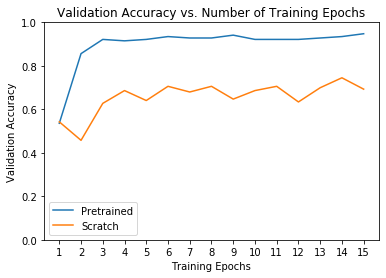

In [30]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()